<a href="https://colab.research.google.com/github/ZahraShahlaie/multi_label_text_classification/blob/main/multi_label_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-label text classification

**Author:** [Farrokh Karimi](https://farrokhkarimi.github.io/)  
**Improver:** [Zahra Shahlaie](https://github.com/ZahraShahlaie)

**Description:** In this notebook, we want to classify the Ronash dataset into 20 category.

In [67]:
import re
import numpy as np
import pandas as pd
import tensorflow as tf
import plotly.express as px


from collections import Counter
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.figure_factory as ff
from sklearn.utils import resample


from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report



In [3]:
# downloading Data from the Google Drive link
!gdown 1Yq3XTnACkvaIiNlhX09Zth55nOau7jQy

Downloading...
From: https://drive.google.com/uc?id=1Yq3XTnACkvaIiNlhX09Zth55nOau7jQy
To: /content/Ronash_DS_Assignment.csv
100% 1.05M/1.05M [00:00<00:00, 25.9MB/s]


In [4]:
ls

Ronash_DS_Assignment.csv  sample_data/


In [5]:
# reading the csv file as a dataframe
df = pd.read_csv('Ronash_DS_Assignment.csv')
df

,product_id,title,vendor,tags,category
0,3937721221199,Fidele Super Premium Adult Large Breed Dog Food,Fidele,"['Adult', 'Bangalore', 'Chennai', 'Chicken', '...",Animals & Pet Supplies
1,7353058033889,Foldable Pet Toys Linen Storage,Cap Point,[],Animals & Pet Supplies
2,6594773549129,Bok Dok Diaper,Pets Home,"['Brand_Pet Arabia', 'Category_Pets Home', 'Ca...",Animals & Pet Supplies
3,4802008318014,Tastybone Toy Chicken,TastyBone,[],Animals & Pet Supplies
4,1779705151539,Leather Leash Tab - Short Dog Leash,Mighty Paw,"['Leash', 'Leash Tab', 'Training']",Animals & Pet Supplies
...,...,...,...,...,...
5265,4637089464407,Candylab MOO Milk Van,Candylab,"['3 Years +', 'candylab', 'Discount Products',...",Vehicles & Parts
5266,4996632444987,"Truck - Modern Era Vehicles -- Red, White - S...",Woodland Scenics,"['HO Scale', 'ho-scale-items', 'vehicles', 'wo...",Vehicles & Parts
5267,5528541003927,Car Sticker Flags Decal American Flag Sticker for,Cyan Selene,['Other'],Vehicles & Parts
5268,1395163889730,Lazer Helmets Bayamo Pit Bull - Full Face,OPEN BOX BARGAINS,"['65061090', 'Antiscratch Pinlock Ready Visor'...",Vehicles & Parts


In [6]:
# counting the number of each label
df['category'].value_counts()

category
Apparel & Accessories        1000
Animals & Pet Supplies        500
Food, Beverages & Tobacco     400
Sporting Goods                400
Luggage & Bags                400
Home & Garden                 400
Health & Beauty               400
Media                         300
Toys & Games                  300
Furniture                     200
Baby & Toddler                200
Arts & Entertainment          200
Electronics                   100
Business & Industrial         100
Office Supplies               100
Vehicles & Parts              100
Hardware                       50
Cameras & Optics               50
Software                       50
Religious & Ceremonial         20
Name: count, dtype: int64

In [7]:
# counting how many indices are duplicated in each column
print(f"There are {sum(df['title'].duplicated())} duplicate title.")
print(f"There are {sum(df['vendor'].duplicated())} duplicate vondor.")
print(f"There are {sum(df['tags'].duplicated())} duplicate tags.")

There are 0 duplicate title.
There are 1256 duplicate vondor.
There are 716 duplicate tags.


In [8]:
# counting the number of Nan samples
df.isnull().values.sum()

3

There are just 3 Nan samples in the dataset so we can ignore them.




# EDA

#### 1. Distribution of products by vendors.

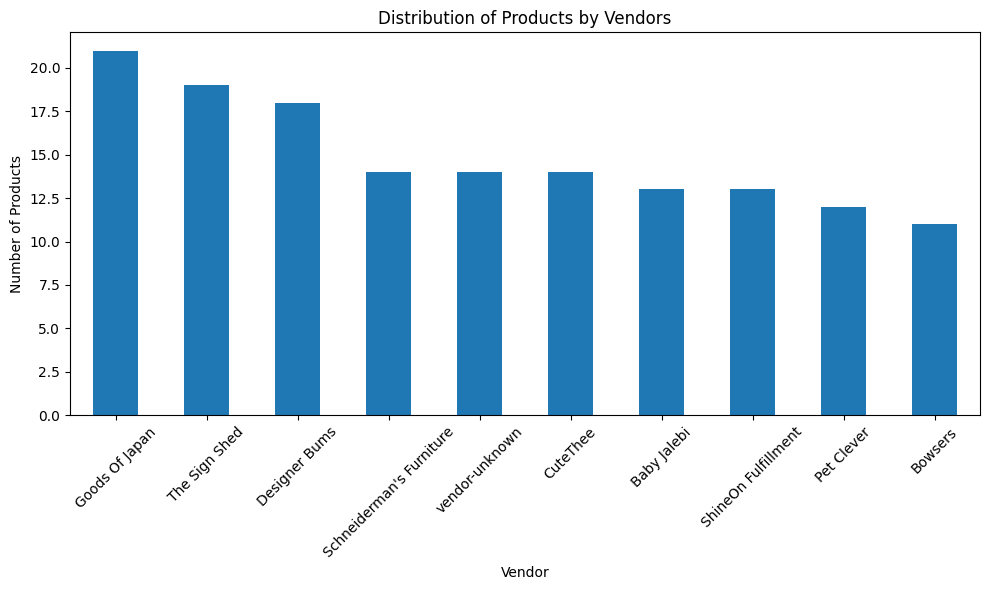

In [14]:
# Count products by vendor
vendor_counts = df['vendor'].value_counts().head(10)

# Displays the distribution based on its tendency
plt.figure(figsize=(10, 6))
vendor_counts.plot(kind='bar')
plt.title('Distribution of Products by Vendors')
plt.xlabel('Vendor')
plt.ylabel('Number of Products')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

2.Pie chart of product distribution by category with Plotly

In [17]:
# Grouping by the 'category' column and counting the number of products in each category
category_counts = df['category'].value_counts()

# Preparing data for Plotly pie chart
fig = px.pie(category_counts, values=category_counts.values, names=category_counts.index,
             title='Product Distribution by Category')

# Display the plot
fig.show()


3. Histogram of the number of tags associated with each product.

In [19]:
# Count the number of tags for each product
df['num_tags'] = df['tags'].apply(lambda x: len(eval(x)))

# Plotting histogram of number of tags
fig = px.histogram(df, x='num_tags', title='Histogram of Number of Tags per Product')

# Customizing layout (optional)
fig.update_layout(
    xaxis_title_text='Number of Tags',
    yaxis_title_text='Count',
)

# Display the plot
fig.show()


#### 4. Bar plot of the top 10 most frequent tags.

In [20]:
# Convert tag strings to lists of tags
df['tags_list'] = df['tags'].apply(eval)

# Combine all tags into one list and count occurrences of each tag
all_tags = []
for tags in df['tags_list']:
    all_tags.extend(tags)

tag_counts = pd.Series(all_tags).value_counts()

# Select the top 10 most frequent tags
top_10_tags = tag_counts.head(10)

# Prepare data for bar plot
fig = px.bar(top_10_tags, x=top_10_tags.index, y=top_10_tags.values,
             labels={'x': 'Tag', 'y': 'Frequency'},
             title='Top 10 Most Frequent Tags')

# Show the plot
fig.show()


### Tokenizing and Standardizing


Tokenize and standardizing the sentences. Also filtering the words based on a predefined regex.

In [24]:
# the function for extracting and standardizing the sentences
def text_extraction(dfi):
  # in this function, we concatenate text feature parts of the data as a sentence
  sentence = ' '.join([dfi['title'], str(dfi['vendor']), dfi['tags']])
  # Remove punctuations
  sentence = re.sub('[^a-zA-Z0-9$.]', ' ', sentence)
  # Single character removal
  sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
  # Removing multiple spaces
  sentence = re.sub(r'\s+', ' ', sentence)
  # Changint to lowercase
  sentence = sentence.lower()
  return sentence

# printing 10 sample sentences
for i in range(10):
  print(text_extraction(df.iloc[i]))

fidele super premium adult large breed dog food fidele adult bangalore chennai chicken doberman dog dry foods fidele german shepherd golden retriever great dane highpriority imported labrador less than 1000 less than 2000 less than 500 mastiff orange pet nutrition 
foldable pet toys linen storage cap point 
bok dok diaper pets home brand pet arabia category pets home category small pets supplies type pet home type pet supplies 
tastybone toy chicken tastybone 
leather leash tab short dog leash mighty paw leash leash tab training 
pridebites texas guitar dog toy pride bites brand pridebites toy type plush 
burns sensitive pork potato burns 10 25 25 50 50 75 adult burns coat dog food food delivery jansale18 natural nonsale19 sensitive size 12kg size 2kg size 6kg skin 
bully sticks dog toy adog.co bully sticks dog chew toys dog toys 
kazoo tough giraffe dog toy kazoo brand kazoo june2021 kazoo material plush plush 
orgo dog biscuits fresh milk petku brand orgo category dogs dogs lifestage

In [27]:
# initializing the dataset
dataset = pd.DataFrame(columns=['text', 'label'])

# list to hold the new rows
rows = []

for i in range(len(df)):
    row = {'text': text_extraction(df.iloc[i]), 'label': df.iloc[i]['category']}
    rows.append(row)

# concatenate rows to the dataset
dataset = pd.concat([dataset, pd.DataFrame(rows)], ignore_index=True)

# creating integer labels for multiclass training
dataset['label_int'] = pd.Categorical(dataset['label']).codes
dataset

,text,label,label_int
0,fidele super premium adult large breed dog foo...,Animals & Pet Supplies,0
1,foldable pet toys linen storage cap point,Animals & Pet Supplies,0
2,bok dok diaper pets home brand pet arabia cate...,Animals & Pet Supplies,0
3,tastybone toy chicken tastybone,Animals & Pet Supplies,0
4,leather leash tab short dog leash mighty paw l...,Animals & Pet Supplies,0
...,...,...,...
5265,candylab moo milk van candylab 3 years candyla...,Vehicles & Parts,19
5266,truck modern era vehicles red white scale ho w...,Vehicles & Parts,19
5267,car sticker flags decal american flag sticker ...,Vehicles & Parts,19
5268,lazer helmets bayamo pit bull full face open b...,Vehicles & Parts,19


In [28]:
# extracting the names of the labels
labels_names = list(Counter(dataset['label']).keys())
labels_names

['Animals & Pet Supplies',
 'Apparel & Accessories',
 'Arts & Entertainment',
 'Baby & Toddler',
 'Business & Industrial',
 'Cameras & Optics',
 'Electronics',
 'Food, Beverages & Tobacco',
 'Furniture',
 'Hardware',
 'Health & Beauty',
 'Home & Garden',
 'Luggage & Bags',
 'Media',
 'Office Supplies',
 'Religious & Ceremonial',
 'Software',
 'Sporting Goods',
 'Toys & Games',
 'Vehicles & Parts']

In [29]:
# printing each integer label and its corresponding name label
for i, label in enumerate(labels_names):
  print("Label", i, "corresponds to", label)

Label 0 corresponds to Animals & Pet Supplies
Label 1 corresponds to Apparel & Accessories
Label 2 corresponds to Arts & Entertainment
Label 3 corresponds to Baby & Toddler
Label 4 corresponds to Business & Industrial
Label 5 corresponds to Cameras & Optics
Label 6 corresponds to Electronics
Label 7 corresponds to Food, Beverages & Tobacco
Label 8 corresponds to Furniture
Label 9 corresponds to Hardware
Label 10 corresponds to Health & Beauty
Label 11 corresponds to Home & Garden
Label 12 corresponds to Luggage & Bags
Label 13 corresponds to Media
Label 14 corresponds to Office Supplies
Label 15 corresponds to Religious & Ceremonial
Label 16 corresponds to Software
Label 17 corresponds to Sporting Goods
Label 18 corresponds to Toys & Games
Label 19 corresponds to Vehicles & Parts


### Balance the Classes
Upsampling:

In [30]:
max_samples = dataset['label'].value_counts().max()
max_samples

1000

In [32]:
for class_name, group in dataset.groupby('label'):
 print(f"Number of {class_name} samples: {len(group)}")

Number of Animals & Pet Supplies samples: 500
Number of Apparel & Accessories samples: 1000
Number of Arts & Entertainment samples: 200
Number of Baby & Toddler samples: 200
Number of Business & Industrial samples: 100
Number of Cameras & Optics samples: 50
Number of Electronics samples: 100
Number of Food, Beverages & Tobacco samples: 400
Number of Furniture samples: 200
Number of Hardware samples: 50
Number of Health & Beauty samples: 400
Number of Home & Garden samples: 400
Number of Luggage & Bags samples: 400
Number of Media samples: 300
Number of Office Supplies samples: 100
Number of Religious & Ceremonial samples: 20
Number of Software samples: 50
Number of Sporting Goods samples: 400
Number of Toys & Games samples: 300
Number of Vehicles & Parts samples: 100


In [34]:
balanced_data_list = []

for class_name, group in dataset.groupby('label'):
    if len(group) < max_samples:
        upsampled_group = resample(group,
                                   replace=True,
                                   n_samples=max_samples,
                                   random_state=42)
    else:
        upsampled_group = group

    balanced_data_list.append(upsampled_group)

balanced_data = pd.concat(balanced_data_list)
balanced_data

,text,label,label_int
102,premium boxer dog reflective harness ploocy bo...,Animals & Pet Supplies,0
435,midwest icrate fold and carry double door coll...,Animals & Pet Supplies,0
348,gourmet deli wfish herring rollover brand roll...,Animals & Pet Supplies,0
270,porkhide knotted bone rollover brand rollover ...,Animals & Pet Supplies,0
106,jbj protein skimmer jbj regular price,Animals & Pet Supplies,0
...,...,...,...
5179,extractor shampoo low foam 3d car care carpet ...,Vehicles & Parts,19
5236,motorcycle amber red turn signal light unbrand...,Vehicles & Parts,19
5187,bennett one box indication unit for bolt elect...,Vehicles & Parts,19
5269,deutz agrotron tractor siku $0 to $25 diecast ...,Vehicles & Parts,19


In [35]:
# Group the data by category and count the number of products in each category
category_counts = balanced_data['label'].value_counts()

# Create a pie chart
fig = px.pie(category_counts, values=category_counts.values,
             names=category_counts.index, title='Product Distribution by Category')

fig.show()

### Data sampling
After standardizing the dataset, It's time to **split** the dataset into train dataset and test datasets. The selected ratio of data is 80% of the dataset for training and 20% of the dataset is for testing and validation. 50% of the testing dataset is for validation and the rest is for testing our model.

In [38]:
# splitting dataset to train, validation, and test dataframes
train_df, test_df= train_test_split(balanced_data, test_size=0.2, random_state=42)
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of samples in training set: {len(train_df)}")
print(f"Number of samples in validation set: {len(val_df)}")
print(f"Number of samples in test set: {len(test_df)}")

# extracting texts and labels from dataframes
train_texts = train_df['text']
train_labels = train_df['label_int']
val_texts = val_df['text']
val_labels = val_df['label_int']
test_texts = test_df['text']
test_labels = test_df['label_int']

Number of samples in training set: 16000
Number of samples in validation set: 2000
Number of samples in test set: 1073


In [39]:
# creating data generators with batch size 32
batch_size = 32
raw_train_batch = tf.data.Dataset.from_tensor_slices((train_texts, train_labels)).batch(batch_size)
raw_val_batch = tf.data.Dataset.from_tensor_slices((val_texts, val_labels)).batch(batch_size)
raw_test_batch = tf.data.Dataset.from_tensor_slices((test_texts, test_labels)).batch(batch_size)

# printing texts and labels of a batch of raw train
for text, label in raw_train_batch.take(1):
  print('Texts: {}'.format(text))
  print('labels: {}'.format(label))

Texts: [b'blackrapid curve breathe black rapid brand black rapid straps slings style camera straps '
 b'bubba bear cot sheet baby jalebi bedding bedding cot sheets bubba bear condition new '
 b'stein world brendan table stein world assembled birch birchwood black cream elk inv elkgroupinternational legs living room furniture sale mdf round rustic stein world stein world accent tables '
 b'quadrello di bufala cheese cut wrapped by igourmet category cheese cut cheeses milk type buffalo nutrition full set origin italy shipping perishable texture semi soft type stinky and washed rind wholesale cheese collection '
 b'frida kahlo standing next to an agave plant toni frissell 2019 agave black white black and white botanicals burrow desert fashion frida frida kahlo frissell kahlo large medium mexico pd artist photography plant plants small toni toni frissell vintage vintage edition vintage editions vogue '
 b'distaut orszaghaz peter zeglis city green landscape photography print water '
 b'fore

In [41]:
# counting how many words are there in the whole texts of the dataset
num_of_words = 0
for i in dataset['text']: num_of_words += len(i.split())

print(num_of_words)

112572


There are about 112000 words in the texts.



In [42]:
# counting max sequence length and how many non-repetitive words are there in the whole texts of the dataset
l = []
max_seq_lenght = 0
for i in dataset['text']:
  lenght = len(i.split())
  if lenght > max_seq_lenght: max_seq_lenght = lenght
  for j in i.split():
    if j not in l: l.append(j)

print(max_seq_lenght)
print(len(l))

309
18933


Maximum sequence length is 309 and There are about 19000 non-repetitive words in the whole dataset texts. So we set max word features to 10000 and sequence length to 350.

In [43]:
# setting the text vectorization layer with 19000 words and 320 sequence length
max_features = 19000     # 10_000 changed to 19_000
sequence_length = 320    # 350 changed to 320

vectorize_layer = layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

# fitting the state of the preprocessing layer to the train set. This will cause the model to build an index of strings to integers.
vectorize_layer.adapt(train_texts)

# defining the vectorize text function
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

# retrieving a sample from a batch of texts and labels from the train set
text_batch, label_batch = next(iter(raw_train_batch))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", first_label)
print("Vectorized text", vectorize_text(first_review, first_label))

Review tf.Tensor(b'blackrapid curve breathe black rapid brand black rapid straps slings style camera straps ', shape=(), dtype=string)
Label tf.Tensor(5, shape=(), dtype=int8)
Vectorized text (<tf.Tensor: shape=(1, 320), dtype=int64, numpy=
array([[4596, 3244, 4590,   12, 2353,   20,   12, 2353, 1124, 4341,   63,
         216, 1124,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,

In [44]:
# getting corresponding word of each integer
print("1401 ---> ",vectorize_layer.get_vocabulary()[1401])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1401 --->  fagus
 313 --->  days
Vocabulary size: 17284


In [45]:
# creating train, val, and test vectorized dataset and prefetching them
train_ds = raw_train_batch.map(vectorize_text)
val_ds = raw_val_batch.map(vectorize_text)
test_ds = raw_test_batch.map(vectorize_text)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [46]:
# model configuration
embedding_dim = 32
num_of_labels = 20

model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(num_of_labels)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          608032    
                                                                 
 dropout (Dropout)           (None, None, 32)          0         
                                                                 
 global_average_pooling1d (  (None, 32)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 20)                660       
                                                                 
Total params: 608692 (2.32 MB)
Trainable params: 608692 (2.32 MB)
Non-trainable params: 0 (0.00 Byte)
____________________

In [47]:
# model compilation
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [48]:
# training the model
epochs = 500

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=5,
                                            verbose=1)

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    callbacks=[callback])

Epoch 1/500
500/500 [==============================] - 7s 12ms/step - loss: 2.9836 - accuracy: 0.1202 - val_loss: 2.9653 - val_accuracy: 0.2160
Epoch 2/500
500/500 [==============================] - 7s 14ms/step - loss: 2.9140 - accuracy: 0.3517 - val_loss: 2.8606 - val_accuracy: 0.4365
Epoch 3/500
500/500 [==============================] - 6s 11ms/step - loss: 2.7528 - accuracy: 0.5871 - val_loss: 2.6759 - val_accuracy: 0.7465
Epoch 4/500
500/500 [==============================] - 5s 11ms/step - loss: 2.5317 - accuracy: 0.7224 - val_loss: 2.4510 - val_accuracy: 0.8380
Epoch 5/500
500/500 [==============================] - 7s 14ms/step - loss: 2.2833 - accuracy: 0.8154 - val_loss: 2.2044 - val_accuracy: 0.8850
Epoch 6/500
500/500 [==============================] - 6s 11ms/step - loss: 2.0262 - accuracy: 0.8643 - val_loss: 1.9579 - val_accuracy: 0.9000
Epoch 7/500
500/500 [==============================] - 6s 12ms/step - loss: 1.7778 - accuracy: 0.8959 - val_loss: 1.7247 - val_accuracy:

In [50]:
# printing loss and accuracy of the model on the test set
loss, accuracy = model.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

34/34 [==============================] - 0s 2ms/step - loss: 0.1043 - accuracy: 0.9786
Loss:  0.10427216440439224
Accuracy:  0.9785647988319397


#### Plot Loss and Accuracy of Model

In [51]:
# extracting the history of training and its keys
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [52]:
# Extract training history
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']
epochs = list(range(1, len(training_loss) + 1))  # Convert range to list

In [55]:
# Create subplots
fig = go.Figure()

# Add training loss plot
fig.add_trace(go.Scatter(x=epochs, y=training_loss, mode='lines+markers', name='Training Loss'))
# Add validation loss plot
fig.add_trace(go.Scatter(x=epochs, y=validation_loss, mode='lines+markers', name='Validation Loss'))

# Update layout
fig.update_layout(title='Training and Validation Metrics',
                  xaxis_title='Epochs',
                  yaxis_title='Value',
                  legend=dict(x=0.7, y=1),
                  template='plotly_dark')

# Show the plot
fig.show()

In [56]:
# Create subplots
fig = go.Figure()

# Add training accuracy plot
fig.add_trace(go.Scatter(x=epochs, y=training_accuracy, mode='lines+markers', name='Training Accuracy'))
# Add validation accuracy plot
fig.add_trace(go.Scatter(x=epochs, y=validation_accuracy, mode='lines+markers', name='Validation Accuracy'))

# Update layout
fig.update_layout(title='Training and Validation Metrics',
                  xaxis_title='Epochs',
                  yaxis_title='Value',
                  legend=dict(x=0.7, y=1),
                  template='plotly_dark')

# Show the plot
fig.show()

In [57]:
# creating the probability model for testing
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

# predicting test samples
predictions = probability_model.predict(raw_test_batch.map(vectorize_text))

34/34 [==============================] - 0s 2ms/step


In [58]:
predicted_labels = []
for i in range(len(predictions)):
    predicted_labels.append(np.argmax(predictions[i]))

#### Confusion Matrix

In [60]:
las = np.array(test_df['label'].unique())
las = las.tolist()


In [65]:
# Compute the confusion matrix
cm = confusion_matrix(np.array(test_df['label_int']), np.array(predicted_labels))

# Create a heatmap for the confusion matrix using Plotly
fig = ff.create_annotated_heatmap(
    z=cm,
    x=las,
    y=las,
    colorscale='Blackbody'
)

# Update the layout
fig.update_layout(
    title="Confusion Matrix",
    xaxis_title="Predicted Label",
    yaxis_title="True Label",
    yaxis_autorange="reversed",
    template='plotly_white'
)

fig.show()

#### Classification Report

In [68]:
print(classification_report(np.array(test_df['label_int']), np.array(predicted_labels)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        62
           1       0.91      0.90      0.91        82
           2       1.00      0.97      0.99        73
           3       0.98      1.00      0.99        58
           4       1.00      1.00      1.00        43
           5       1.00      1.00      1.00        15
           6       1.00      1.00      1.00        33
           7       1.00      1.00      1.00        75
           8       1.00      0.98      0.99        63
           9       1.00      1.00      1.00        12
          10       0.99      0.98      0.98        81
          11       0.96      0.99      0.98        81
          12       1.00      0.98      0.99        81
          13       1.00      0.99      0.99        72
          14       1.00      1.00      1.00        27
          16       1.00      1.00      1.00        10
          17       0.96      0.95      0.95        91
          18       0.93    

#### Check Model

In [69]:
# showing the first test sample result label
np.argmax(predictions[0])

10

In [70]:
# showing the true label of the first test sample
test_df.iloc[0]

text         colour up colour protection hair bath oway col...
label                                          Health & Beauty
label_int                                                   10
Name: 2856, dtype: object

## Finally in this code we achieved, loss: 0.1043 - accuracy: 0.9786




**Author:** https://farrokhkarimi.github.io/

**Editor:** [Zahra Shahlaie](https://github.com/ZahraShahlaie)